In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from functools import partial, reduce
import re, math, random

In [2]:
#
# functions for working with vectors
#

def vector_add(v, w):
    """adds two vectors componentwise"""
    return [v_i + w_i for v_i, w_i in zip(v,w)]

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def vector_sum(vectors):
    return reduce(vector_add, vectors)

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """compute the vector whose i-th element is the mean of the
    i-th elements of the input vectors"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def magnitude(v):
    return math.sqrt(sum_of_squares(v))

def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
   return math.sqrt(squared_distance(v, w))

## 8.1 梯度下降思想

## 8.2 估算梯度   
差商估算法：直接使用微分的定義暴力估算

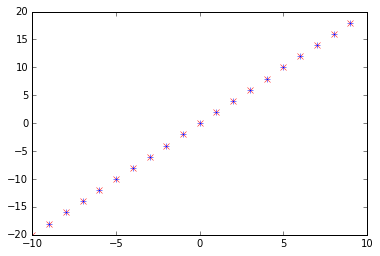

In [3]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

def plot_estimated_derivative():

    def square(x):
        return x * x

    def derivative(x):
        return 2 * x

    derivative_estimate = lambda x: difference_quotient(square, x, h=0.00001)

    # plot to show they're basically the same
    import matplotlib.pyplot as plt
    x = range(-10,10)
    plt.plot(x, list(map(derivative, x)), 'rx')           # red  x
    plt.plot(x, list(map(derivative_estimate, x)), 'b+')  # blue +
    plt.show()                                      # purple *, hopefully

plot_estimated_derivative()

In [4]:
def partial_difference_quotient(f, v, i, h):

    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]

## 8.3 使用梯度
這個範例很奇怪，沒有使用微分，就是直接拿結果值硬幹，換句話說步長是錯的   
阿，我誤會了，我們算的是平方，他已過一次了

In [5]:
def step(v, direction, step_size):
    """
    move step_size in the direction from v
    搞笑，方向應該是逆梯度，但不包含在這個函數，在 step_size 的參數中加上負值
    """
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

# 對平方作微分
def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

# pick a random starting point
v = [random.randint(-10,10) for i in range(3)]

tolerance = 0.0000001

while True:
    gradient = sum_of_squares_gradient(v) 
    next_v = step(v, gradient, -0.01) #搞笑，步長是負的參數放在這裡
    if distance(next_v, v) < tolerance:
        break
    v = next_v
v

[1.3601098330270884e-06, 1.3601098330270884e-06, 4.533699443423632e-06]

## 8.4 選擇正確步長
選擇步長是藝術，這裡建議每一步使用最小化目標函數來達到   
但是有些步長可能會導致錯誤，所以要加一個safe函數，如下  


In [6]:
def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

## 8.5 綜合
這個範例很奇怪，沒有使用微分，就是直接拿結果值硬幹

In [7]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]
        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn) # 注意 key 的妙用
        next_value = target_fn(next_theta)
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

In [8]:
print("using minimize_batch")

v = [random.randint(-10,10) for i in range(3)]

v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)

print("minimum v", v)
print("minimum value", sum_of_squares(v))

using minimize_batch
minimum v [0.001063382396627933, 0.00031901471898837996, -0.001063382396627933]
minimum value 2.3633346338475687e-06


In [9]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

## 8.6 隨機梯度下降法
有點看不太懂 stochastic 與 batch的差別

In [68]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes[:len(data) // 2]:         # return the data in that order @ 只取部分樣本
        yield data[i]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9


        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

書後面關於線性回歸的範例  
到目前為止看起來 batch 與 stochastic 的版本差別是差在
batch 算過所有樣本點才 iterate 一次，而 stochastic 每次只 iterate 一個樣本點
不過還是有點奇怪，那個 for 迴圈中每個樣本點跑一次後才結束，那是不是random有差嗎@@   
或每次只interate一個樣本，順序會對結果產生差異  
而且在別的文章看來，或許不用所有樣本點都取到也可以算出來  
所以經過實驗，random中只取部分樣本也是可以算出來

In [61]:
def predict(alpha, beta, x_i):
    return beta * x_i + alpha

def error(alpha, beta, x_i, y_i):
    return y_i - predict(alpha, beta, x_i)

def sum_of_squared_errors(alpha, beta, x, y):
    return sum(error(alpha, beta, x_i, y_i) ** 2
               for x_i, y_i in zip(x, y))

def least_squares_fit(x,y):
    """given training values for x and y,
    find the least-squares values of alpha and beta"""
    beta = correlation(x, y) * standard_deviation(y) / standard_deviation(x)
    alpha = mean(y) - beta * mean(x)
    return alpha, beta

def total_sum_of_squares(y):
    """the total squared variation of y_i's from their mean"""
    return sum(v ** 2 for v in de_mean(y))

def r_squared(alpha, beta, x, y):
    """the fraction of variation in y captured by the model, which equals
    1 - the fraction of variation in y not captured by the model"""

    return 1.0 - (sum_of_squared_errors(alpha, beta, x, y) /
                  total_sum_of_squares(y))

def squared_error(x_i, y_i, theta):
    alpha, beta = theta
    return error(alpha, beta, x_i, y_i) ** 2

def squared_error_gradient(x_i, y_i, theta):
    alpha, beta = theta
    return [-2 * error(alpha, beta, x_i, y_i),       # alpha partial derivative
            -2 * error(alpha, beta, x_i, y_i) * x_i] # beta partial derivative


In [67]:
from stats import mean, correlation, standard_deviation, de_mean

num_friends_good = [49,41,40,25,21,21,19,19,18,18,16,15,15,15,15,14,14,13,13,13,13,12,12,11,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
daily_minutes_good = [68.77,51.25,52.08,38.36,44.54,57.13,51.4,41.42,31.22,34.76,54.01,38.79,47.59,49.1,27.66,41.03,36.73,48.65,28.12,46.62,35.57,32.98,35,26.07,23.77,39.73,40.57,31.65,31.21,36.32,20.45,21.93,26.02,27.34,23.49,46.94,30.5,33.8,24.23,21.4,27.94,32.24,40.57,25.07,19.42,22.39,18.42,46.96,23.72,26.41,26.97,36.76,40.32,35.02,29.47,30.2,31,38.11,38.18,36.31,21.03,30.86,36.07,28.66,29.08,37.28,15.28,24.17,22.31,30.17,25.53,19.85,35.37,44.6,17.23,13.47,26.33,35.02,32.09,24.81,19.33,28.77,24.26,31.98,25.73,24.86,16.28,34.51,15.23,39.72,40.8,26.06,35.76,34.76,16.13,44.04,18.03,19.65,32.62,35.59,39.43,14.18,35.24,40.13,41.82,35.45,36.07,43.67,24.61,20.9,21.9,18.79,27.61,27.21,26.61,29.77,20.59,27.53,13.82,33.2,25,33.1,36.65,18.63,14.87,22.2,36.81,25.53,24.62,26.25,18.21,28.08,19.42,29.79,32.8,35.99,28.32,27.79,35.88,29.06,36.28,14.1,36.63,37.49,26.9,18.58,38.48,24.48,18.95,33.55,14.24,29.04,32.51,25.63,22.22,19,32.73,15.16,13.9,27.2,32.01,29.27,33,13.74,20.42,27.32,18.23,35.35,28.48,9.08,24.62,20.12,35.26,19.92,31.02,16.49,12.16,30.7,31.22,34.65,13.13,27.51,33.2,31.57,14.1,33.42,17.44,10.12,24.42,9.82,23.39,30.93,15.03,21.67,31.09,33.29,22.61,26.89,23.48,8.38,27.81,32.35,23.84]

alpha, beta = least_squares_fit(num_friends_good, daily_minutes_good)
print("alpha", alpha)
print("beta", beta)

print("r-squared", r_squared(alpha, beta, num_friends_good, daily_minutes_good))

print()

print("gradient descent:")
# choose random value to start
random.seed(0)
theta = [random.random(), random.random()]
alpha, beta = minimize_stochastic(squared_error,
                                  squared_error_gradient,
                                  num_friends_good,
                                  daily_minutes_good,
                                  theta,
                                  0.0001)
print("alpha", alpha)
print("beta", beta)


alpha 22.94755241346903
beta 0.903865945605865
r-squared 0.3291078377836305

gradient descent:
alpha 22.64747007529572
beta 0.9263290359289186


In [21]:
alpha 22.93746417548679
beta 0.9043371597664965

203

In [47]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]
 
def in_random_order_2(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes[:len(data) // 2]:                          # return the data in that order
        yield data[i]
        

In [48]:
list(in_random_order([1,2,3,4,5,6,7,8,9,0]))

[8, 1, 0, 4, 3, 6, 7, 9, 2, 5]

In [49]:
list(in_random_order_2([1,2,3,4,5,6,7,8,9,0]))

[1, 3, 9, 4, 2]